In [1]:
from dataset import SubjectTrialDataset_SingleElectrode
from subject_braintreebank import BrainTreebankSubject
import torch
from model_model import BFModule
from model_transformers import Transformer
import torch.nn as nn
import time
import psutil

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

subject_id, trial_id = 3, 0
window_size = 1280
subject = BrainTreebankSubject(subject_id, cache=True)
electrode_subset = subject.get_electrode_labels(trial_id)[:1]
dataset = SubjectTrialDataset_SingleElectrode(subject, trial_id, window_size=window_size, dtype=torch.float32, unsqueeze_electrode_dimension=False, electrodes_subset=electrode_subset)

def log(message, indent=0):
    current_time = time.strftime("%H:%M:%S")
    gpu_memory_reserved = torch.cuda.memory_reserved() / 1024**3 if torch.cuda.is_available() else 0
    process = psutil.Process()
    ram_usage = process.memory_info().rss / 1024**3
    print(f"[{current_time} gpu {gpu_memory_reserved:.1f}G ram {ram_usage:.1f}G] {' '*4*indent}{message}")

Using device: cuda


In [8]:
len(dataset) / 128

85.546875

In [110]:
class Embed(BFModule):
    def __init__(self, d_input, d_model):
        super().__init__()
        self.d_model = d_model
        self.embed = nn.Linear(d_input, d_model)
    def forward(self, x):
        return self.embed(x)

class Model(BFModule):
    def __init__():
        pass

    def generate_continuation(self, batch, n_steps, vocab):
        """
        Generate a continuation of the input sequence for n_steps steps.
        
        Args:
            batch: Input sequence of shape (batch_size, seq_len, 1)
            n_steps: Number of steps to generate
            vocab: Tensor of possible samples to choose from, shape (n_samples, d_model)
        
        Returns:
            Tensor of shape (batch_size, seq_len + n_steps, 1) containing the original sequence
            concatenated with the generated continuation
        """
        # Start with the input batch
        current_sequence = batch.clone()
        # Generate n_steps new timesteps
        for _ in range(n_steps):
            # Get next step prediction
            next_values = self.generate_next_step(current_sequence, vocab).unsqueeze(1)
            # Concatenate with current sequence
            current_sequence = torch.cat([current_sequence, next_values], dim=1)
        return current_sequence
    
class ContrastiveModel(Model):
    def __init__(self, d_model=128, n_layers=4, n_heads=8, d_input=1):
        super(Model, self).__init__()
        self.d_input = d_input
        self.d_model = d_model
        self.n_layers = n_layers
        self.n_heads = n_heads
        self.embed = nn.Linear(d_input, d_model)
        self.unembed = nn.Linear(d_input, d_model)
        self.transformer = Transformer(d_input=d_model, d_model=d_model, d_output=d_model, 
                                        n_layer=n_layers, n_head=n_heads, causal=True, 
                                        rope=True, cls_token=False, rope_base=2560 // d_input)
        # self.embed = Transformer(d_input=d_input, d_model=d_model, d_output=d_model, 
        #                                 n_layer=n_layers, n_head=n_heads, causal=True, 
        #                                 rope=True, cls_token=False, rope_base=2560 // d_input)
        mlp_hidden_dim = d_model * 4
        self.embed = nn.Sequential(
            nn.Linear(d_input, mlp_hidden_dim),
            nn.ReLU(),
            *[nn.Sequential(
                nn.ReLU(),
                nn.Linear(mlp_hidden_dim, mlp_hidden_dim)
            ) for _ in range(n_layers-2)],
            nn.ReLU(),
            nn.Linear(mlp_hidden_dim, d_model)
        )
        self.unembed = nn.Sequential(
            nn.Linear(d_input, mlp_hidden_dim),
            nn.ReLU(),
            *[nn.Sequential(
                nn.ReLU(),
                nn.Linear(mlp_hidden_dim, mlp_hidden_dim)
            ) for _ in range(n_layers-2)],
            nn.ReLU(),
            nn.Linear(mlp_hidden_dim, d_model)
        )
    
    def forward(self, x, y):
        # x is of shape (batch_size, seq_len, d_input)
        # y is of shape (batch_size, seq_len, d_input)
        batch_size_x, seq_len_x, d_input = x.shape
        batch_size_y, seq_len_y, d_input = y.shape
        x = x.reshape(batch_size_x*seq_len_x, 1, d_input)
        y = y.reshape(batch_size_y*seq_len_y, 1, d_input)
        x = self.embed(x) # shape (batch_size, seq_len, d_model)
        y = self.unembed(y) # shape (batch_size, seq_len, d_model)
        x = x.reshape(batch_size_x, seq_len_x, self.d_model)
        y = y.reshape(batch_size_y, seq_len_y, self.d_model)

        x = self.transformer(x) # shape (batch_size, seq_len, d_model)

        # x = x / (x.norm(dim=-1, keepdim=True) + 1e-5)
        # y = y / (y.norm(dim=-1, keepdim=True) + 1e-5)
        return x, y
        
    def calculate_loss(self, batch):
        # batch is of shape (batch_size, seq_len, d_input)
        x, y = self(batch[:, :-1], batch[:, 1:])
        batch_size = batch.shape[0]

        similarity = torch.matmul(x[:, :].permute(1, 0, 2), y[:, :].permute(1, 2, 0))
        expanded_arange = torch.arange(batch_size).unsqueeze(0).repeat(x.shape[1], 1).to(device, dtype=torch.long).reshape(-1)
        loss = torch.nn.functional.cross_entropy(similarity.view(-1, batch_size), expanded_arange)
        return loss
    
    def generate_next_step(self, batch, vocab):
        # batch is of shape (batch_size, seq_len, 1)
        # vocab is of shape (n_samples,)
        x = batch
        y = vocab.unsqueeze(0) # shape (1, n_samples, 1)
        x, y = self(x, y)
        last_x = x[:, -1:] # shape (batch_size, 1, d_model)
        
        # Calculate similarity with all possible next steps
        similarity = torch.matmul(last_x, y.transpose(-2, -1)) # shape (batch_size, 1, seq_len)
        # Convert to probabilities
        probs = torch.softmax(similarity.squeeze(1), dim=-1)
        # Sample from probability distribution
        next_idx = torch.multinomial(probs, num_samples=1).squeeze(-1)
        next_value = vocab[next_idx]
        return next_value
    
class RawL2Model(Model):
    def __init__(self, d_model=128, n_layers=4, n_heads=8, d_input=1):
        super().__init__()
        self.d_input = d_input
        self.d_model = d_model
        self.n_layers = n_layers
        self.n_heads = n_heads
        self.embed = torch.nn.Linear(d_input, d_model)
        self.unembed = torch.nn.Linear(d_model, d_input)
        self.transformer = Transformer(d_input=d_model, d_model=d_model, d_output=d_model, 
                                        n_layer=n_layers, n_head=n_heads, causal=True, 
                                        rope=True, cls_token=False, rope_base=2560 // d_input)
        
    def forward(self, x):
        x = self.embed(x) # shape (batch_size, seq_len, d_model)
        x = self.transformer(x) # shape (batch_size, seq_len, d_model)
        x = self.unembed(x) # shape (batch_size, seq_len, d_input)
        return x
        
    def calculate_loss(self, batch):
        x = self(batch[:, :-1])
        y = batch[:, 1:]
        loss = (x-y).pow(2).mean()
        return loss
    
    def generate_next_step(self, batch):
        x = self(batch)[:, -1:]
        return x

In [111]:
n_steps = 2000
batch_size = 128
import itertools
dataloader = iter(torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True))
dataloader = iter(itertools.cycle(dataloader))


n_samples_per_bin = 4
model = ContrastiveModel(d_input=n_samples_per_bin).to(device)

initial_lr = 0.003
use_muon = False
optimizers = []
schedulers = []
if use_muon:
    from muon import Muon
    all_params = list(model.parameters())
    matrix_params = [p for p in all_params if p.ndim >= 2]
    other_params = [p for p in all_params if p.ndim < 2]
    optimizers.append(Muon(matrix_params, lr=initial_lr, momentum=0.95, nesterov=True, backend='newtonschulz5', backend_steps=5))
    optimizers.append(torch.optim.AdamW(other_params, lr=initial_lr, betas=(0.9, 0.95)))
    schedulers.append(None)  # Muon doesn't support schedulers
    schedulers.append(torch.optim.lr_scheduler.LinearLR(optimizers[1], start_factor=1.0, end_factor=0.0, total_iters=n_steps))
else:
    optimizers = [torch.optim.AdamW(model.parameters(), lr=initial_lr, betas=(0.9, 0.95))]
    schedulers = [torch.optim.lr_scheduler.LinearLR(optimizers[0], start_factor=1.0, end_factor=0.0, total_iters=n_steps)]

step = 1
for batch in dataloader:
    for optimizer in optimizers:
        optimizer.zero_grad()

    batch_data = batch['data'].to(device).reshape(batch_size, window_size//n_samples_per_bin, n_samples_per_bin) # shape (batch_size, seq_len, 1)
    batch_data /= 100

    loss = model.calculate_loss(batch_data)
    loss.backward()
    for optimizer in optimizers:
        optimizer.step()
    
    # Step the schedulers
    for scheduler in schedulers:
        if scheduler is not None:
            scheduler.step()
    
    if step % 100 == 0:
        current_lr = optimizers[-1].param_groups[0]['lr']
        print(f"Step {step}, Loss: {loss.item():.4f}, LR: {current_lr:.6f}")
        
    if step == n_steps:
        break # Only process one batch per step
    step += 1


Step 100, Loss: 2.6535, LR: 0.002850
Step 200, Loss: 2.2905, LR: 0.002700
Step 300, Loss: 2.2206, LR: 0.002550
Step 400, Loss: 2.2397, LR: 0.002400
Step 500, Loss: 2.1305, LR: 0.002250
Step 600, Loss: 2.1425, LR: 0.002100
Step 700, Loss: 2.0070, LR: 0.001950
Step 800, Loss: 1.9580, LR: 0.001800
Step 900, Loss: 1.9351, LR: 0.001650
Step 1000, Loss: 1.9421, LR: 0.001500
Step 1100, Loss: 1.8900, LR: 0.001350
Step 1200, Loss: 1.8746, LR: 0.001200
Step 1300, Loss: 1.8362, LR: 0.001050
Step 1400, Loss: 1.8749, LR: 0.000900
Step 1500, Loss: 1.8989, LR: 0.000750
Step 1600, Loss: 1.7965, LR: 0.000600
Step 1700, Loss: 1.7871, LR: 0.000450
Step 1800, Loss: 1.7548, LR: 0.000300
Step 1900, Loss: 1.6853, LR: 0.000150
Step 2000, Loss: 1.6165, LR: 0.000000


In [112]:
import random

vocab_size = 10000
vocab = []
for i in range(vocab_size // (window_size // n_samples_per_bin)):
    vocab.append(dataset[random.randint(0, len(dataset)-1)]['data'].reshape(window_size//n_samples_per_bin, n_samples_per_bin))
    vocab[-1] /= 100
vocab = torch.cat(vocab, dim=0)
vocab = vocab.to(device)
vocab_size = len(vocab)
print(vocab.shape)

torch.Size([9920, 4])


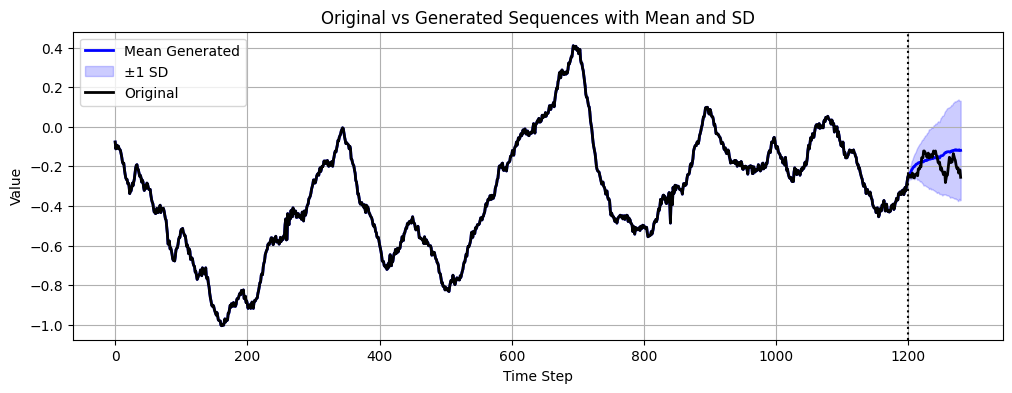

In [116]:
generate_steps = 20
n_generations = 100
batch_index = random.randint(0, len(dataset)-1)

example_seq = dataset[batch_index]['data'].reshape(window_size//n_samples_per_bin, n_samples_per_bin).unsqueeze(0).to(device)
example_seq = example_seq.expand(n_generations, -1, -1)
example_seq = example_seq / 100
continued_seq = model.generate_continuation(example_seq[:, :example_seq.shape[1]-generate_steps], generate_steps, vocab)

example_seq = example_seq[0,:].detach().cpu().numpy().flatten()

import matplotlib.pyplot as plt
import numpy as np

# Plot original and continued sequences
plt.figure(figsize=(12,4))

# Convert continued sequences to numpy array for statistics
continued_seqs_np = np.array([seq.detach().cpu().numpy().flatten() for seq in continued_seq])
mean_seq = np.mean(continued_seqs_np, axis=0)
std_seq = np.std(continued_seqs_np, axis=0)

# Plot individual continued sequences
# for i in range(n_generations):
#     continued_seq_item = continued_seqs_np[i]
#     plt.plot(continued_seq_item, '--', label='Generated' if i == 0 else None, alpha=0.2, color='red', linewidth=1)

# Plot mean and standard deviation
plt.plot(mean_seq, '-', color='blue', label='Mean Generated', linewidth=2)
plt.fill_between(range(len(mean_seq)), mean_seq-std_seq, mean_seq+std_seq, color='blue', alpha=0.2, label='±1 SD')
    
# Plot original sequence
plt.plot(example_seq, label='Original', alpha=1.0, color='k', linewidth=2)

# Add vertical line where generation starts
plt.axvline(x=example_seq.shape[0]-generate_steps*n_samples_per_bin, color='k', linestyle=':')

plt.legend()
plt.title('Original vs Generated Sequences with Mean and SD')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.grid(True)
plt.show()
